In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "3,4,5,6,7,8,9"

In [3]:
os.chdir('/export/home/bguenes/COMPASS/')
from src.compass import ScoreBasedInferenceModel as SBIm
from src.compass import ModelTransfuser as MTf
os.chdir('/export/home/bguenes/COMPASS/tutorials')

In [4]:
# from compass import ScoreBasedInferenceModel as SBIm
# from compass import ModelTransfuser as MTf

In [5]:
import torch

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# --- 1. General ODE Solver (using simple Euler method) ---
def solve_ode(model_func, initial_state, params, t_max, dt):
    """
    Solves a system of ODEs using the Euler method.

    Args:
        model_func (function): The function defining the ODEs (e.g., lotka_volterra).
        initial_state (torch.Tensor): The starting values [N, P].
        params (dict): A dictionary of parameters for the model.
        t_max (int): The maximum simulation time.
        dt (float): The time step.

    Returns:
        (torch.Tensor, torch.Tensor): Tensors for time points and population history.
    """
    # Setup time steps and history arrays
    time_steps = torch.arange(0, t_max, dt)
    history = torch.zeros(initial_state.shape[0], len(time_steps), 2)
    history[:, 0, :] = initial_state
    
    # Current state starts at the initial state
    current_state = initial_state.clone()

    # Euler integration loop
    for i in range(1, len(time_steps)):
        # Get the derivatives from the model function
        derivatives = model_func(current_state, params)
        # Update the state using the Euler step
        current_state += derivatives * dt
        # Ensure populations don't go below zero
        current_state = torch.max(current_state, torch.tensor([0.0, 0.0]))
        history[:, i, :] = current_state
        
    return time_steps, history

In [7]:
# --- 2. The Four Competing Model Functions ---
# Each model uses exactly four parameters: {r, a, m, K}

def lotka_volterra(state, params):
    """Model 1: Classic Lotka-Volterra dynamics."""
    N, P = state.T
    r, a, m, K = params.T
    b = K / 100.0 # Conversion efficiency

    dN_dt = r * N - a * N * P
    dP_dt = b * a * N * P - m * P
    return torch.stack([dN_dt, dP_dt]).T

def logistic_prey(state, params):
    """Model 2: Prey with logistic growth."""
    N, P = state.T
    r, a, m, K = params.T
    b = 0.5 # Fixed conversion efficiency
    
    dN_dt = r * N * (1 - N / K) - a * N * P
    dP_dt = b * a * N * P - m * P
    return torch.stack([dN_dt, dP_dt]).T

def satiated_predator(state, params):
    """Model 3: Predator with satiation (Holling Type II)."""
    N, P = state.T
    r, a, m, K = params.T
    b = 0.5 # Fixed conversion efficiency
    h = K / 100.0 # Let K control handling time

    consumption = (a * N) / (1 + a * h * N)
    dN_dt = r * N - consumption * P
    dP_dt = b * consumption * P - m * P
    return torch.stack([dN_dt, dP_dt]).T

def rosenzweig_macarthur(state, params):
    """Model 4: Both logistic prey and satiated predator."""
    N, P = state.T
    r, a, m, K = params.T
    b = 0.5 # Fixed conversion efficiency
    h = 0.1 # Fixed handling time

    consumption = (a * N) / (1 + a * h * N)
    dN_dt = r * N * (1 - N / K) - consumption * P
    dP_dt = b * consumption * P - m * P
    return torch.stack([dN_dt, dP_dt]).T

In [8]:
# --- 3. Simulation Setup ---

# Parameters (chosen to show interesting dynamics)
# Note: Not all models use all parameters
params = torch.tensor([[1.0, 0.1, 0.4, 40.0]])
# {
#     'r': 1.0,   # Prey intrinsic growth rate
#     'a': 0.1,   # Predator attack rate
#     'm': 0.4,   # Predator mortality rate
#     'K': 40.0,  # Prey carrying capacity
# }

# Initial conditions [N0, P0]
initial_state = torch.tensor([[20.0, 30.0]])

# Simulation time
t_max = 100
dt = 0.01

# List of models to run
models = {
    "Lotka-Volterra": lotka_volterra,
    "Logistic Prey": logistic_prey,
    "Satiated Predator": satiated_predator,
    "Rosenzweig-MacArthur": rosenzweig_macarthur
}

In [9]:

# --- 4. Run Simulations and Collect Data ---

# A list to store all results for plotting
all_results = []

for model_name, model_func in models.items():
    # Run the solver for the current model
    time, history = solve_ode(model_func, initial_state, params, t_max, dt)
    
    # Convert results to NumPy for Pandas
    time_np = time.numpy()
    history_np = history.numpy()
    
    # Format data into a "tidy" DataFrame for Seaborn
    df_prey = pd.DataFrame({
        'time': time_np,
        'population': history_np[0, :, 0],
        'species': 'Prey',
        'model': model_name
    })
    
    df_predator = pd.DataFrame({
        'time': time_np,
        'population': history_np[0, :, 1],
        'species': 'Predator',
        'model': model_name
    })
    
    all_results.append(df_prey)
    all_results.append(df_predator)

# Combine all individual DataFrames into a single one
results_df = pd.concat(all_results)

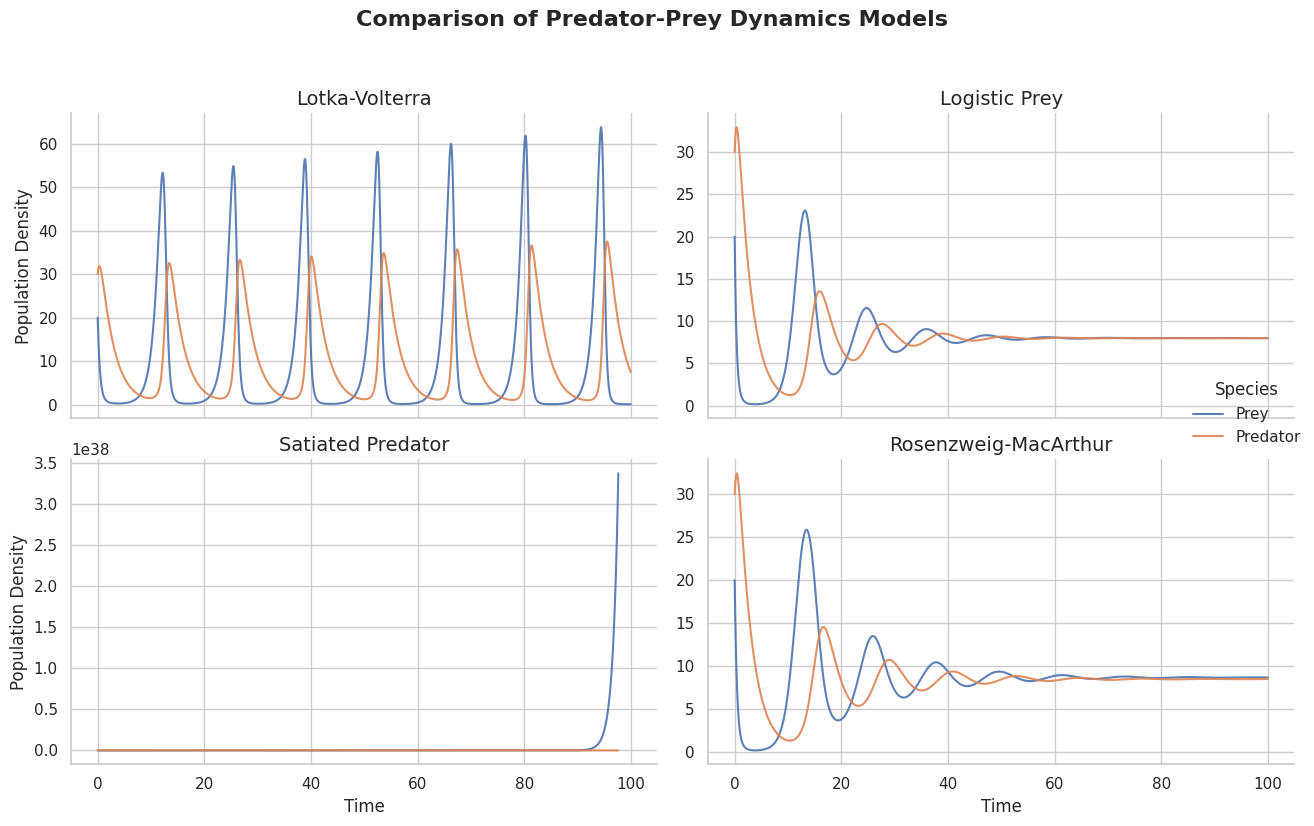

In [10]:

# --- 5. Visualization using Seaborn ---

# Set a nice style
sns.set_theme(style="whitegrid")

# Create a FacetGrid to plot each model in its own subplot
g = sns.FacetGrid(results_df, col="model", col_wrap=2, hue="species", height=4, aspect=1.5, sharey=False)

# Map the lineplot onto the grid
g.map(sns.lineplot, "time", "population", alpha=0.9)

# Add titles, legends, and labels
g.set_titles("{col_name}", size=14)
g.set_axis_labels("Time", "Population Density")
g.add_legend(title="Species")
g.fig.suptitle("Comparison of Predator-Prey Dynamics Models", y=1.03, fontsize=16, weight='bold')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Lynx and Hare Population Dynamics

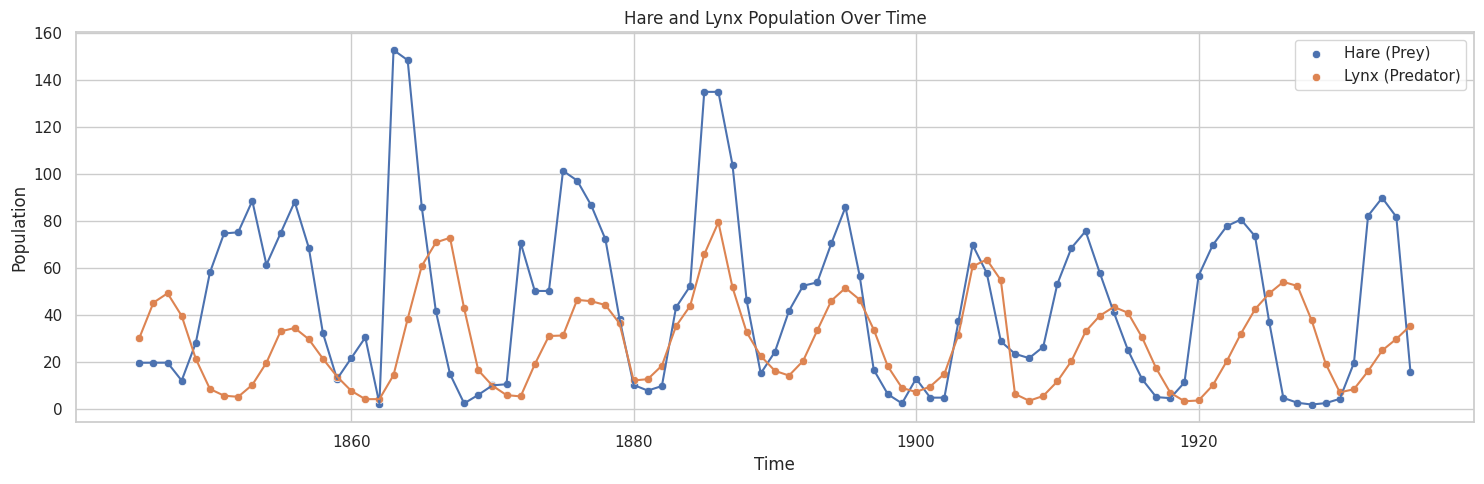

In [11]:
url = 'http://people.whitman.edu/~hundledr/courses/M250F03/LynxHare.txt'
df = pd.read_csv(url, sep=r'\s+', header=None, index_col=0)
df.index.name = 'Year'
df.columns = ['Hare', 'Lynx']

time = torch.tensor(df.index.values)
df.index = df.index - df.index.min()
index = torch.tensor(df.index.values)
hare, lynx = torch.tensor(df['Hare'].values), torch.tensor(df['Lynx'].values)


plt.figure(figsize=(15,5))
sns.scatterplot(x=time, y=hare, label='Hare (Prey)')
sns.lineplot(x=time, y=hare)
sns.scatterplot(x=time, y=lynx, label='Lynx (Predator)')
sns.lineplot(x=time, y=lynx)


plt.legend()
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Hare and Lynx Population Over Time')
plt.tight_layout()
plt.show()

## Create Training Data

In [12]:
class prior_distributions:
    def __init__(self):
        self.N = torch.distributions.Uniform(0, 200)
        self.P = torch.distributions.Uniform(0, 200)
        self.r = torch.distributions.Uniform(0, 1)
        self.a = torch.distributions.Uniform(0, 1)
        self.m = torch.distributions.Uniform(0, 1)
        self.K = torch.distributions.Uniform(0, 100)

    def sample(self, num_samples=1):
        N = self.N.sample((num_samples,))
        P = self.P.sample((num_samples,))
        r = self.r.sample((num_samples,))
        a = self.a.sample((num_samples,))
        m = self.m.sample((num_samples,))
        K = self.K.sample((num_samples,))

        init_state = torch.stack([N, P], dim=-1)
        params = torch.stack([r, a, m, K], dim=-1)

        return init_state, params

prior = prior_distributions()

In [13]:
training_data = {}
validation_data = {}

for model_name, model_func in models.items():
    # Sample initial conditions and parameters
    init_state, params = prior.sample(100_000)
    val_init_state, val_params = prior.sample(1_000)

    t_max = 30
    dt = 0.01

    # -----------------
    # Training Data
    time, history = solve_ode(model_func, init_state, params, t_max, dt)
    
    # get full timestep data
    data = history[:, time % 1 == 0]
    data = data.flatten(1)

    # Store the training data
    training_data[model_name] = {
        "theta": params,
        "x": data
    }

    # -----------------
    # Validation Data
    time, history = solve_ode(model_func, val_init_state, val_params, t_max, dt)

    # get full timestep data
    data = history[:, time % 1 == 0]
    data = data.flatten(1)

    # Store the validation data
    validation_data[model_name] = {
        "theta": val_params,
        "x": data
    }


## Initialize COMPASS

In [14]:
mtf = MTf(path="data/predator_prey")

In [16]:
# Load the pretrained models

for model_name, _ in models.items():
    sbim = SBIm.load(f"data/predator_prey/{model_name}_checkpoint.pt", device="cuda")
    mtf.add_model(model_name, sbim)

Model Lotka-Volterra added to transfuser.
Model Logistic Prey added to transfuser.
Model Satiated Predator added to transfuser.
Model Rosenzweig-MacArthur added to transfuser.


In [13]:
for model_name, model_func in models.items():
    theta = training_data[model_name]["theta"]
    x = training_data[model_name]["x"]
    val_theta = validation_data[model_name]["theta"]
    val_x = validation_data[model_name]["x"]
    
    mtf.add_data(model_name, theta, x, val_theta, val_x)

Data added to model Lotka-Volterra
Data added to model Logistic Prey
Data added to model Satiated Predator
Data added to model Rosenzweig-MacArthur


In [14]:
mtf.init_models(sde_type='vesde', sigma=10, hidden_size=20, depth=5, num_heads=5, mlp_ratio=5)

Models initialized: ['Lotka-Volterra', 'Logistic Prey', 'Satiated Predator', 'Rosenzweig-MacArthur']


In [15]:
mtf.train_models(batch_size=256)

Model Lotka-Volterra trained
Model Logistic Prey trained
Model Satiated Predator trained
Model Rosenzweig-MacArthur trained


In [77]:
data = torch.stack([hare, lynx], dim=-1).flatten().unfold(0, 60, 1).float()

In [79]:
mtf.compare(x=data, device="cuda", timesteps=100, method="dpm", order=1)

Probabilities of the models after 123 observations:
Lotka-Volterra      :   0.00 %
Logistic Prey       :   0.00 %
Satiated Predator   : 100.00 %
Rosenzweig-MacArthur:   0.00 %

Model Satiated Predator fits the data best with a relative support of 100.0% among the considered models.


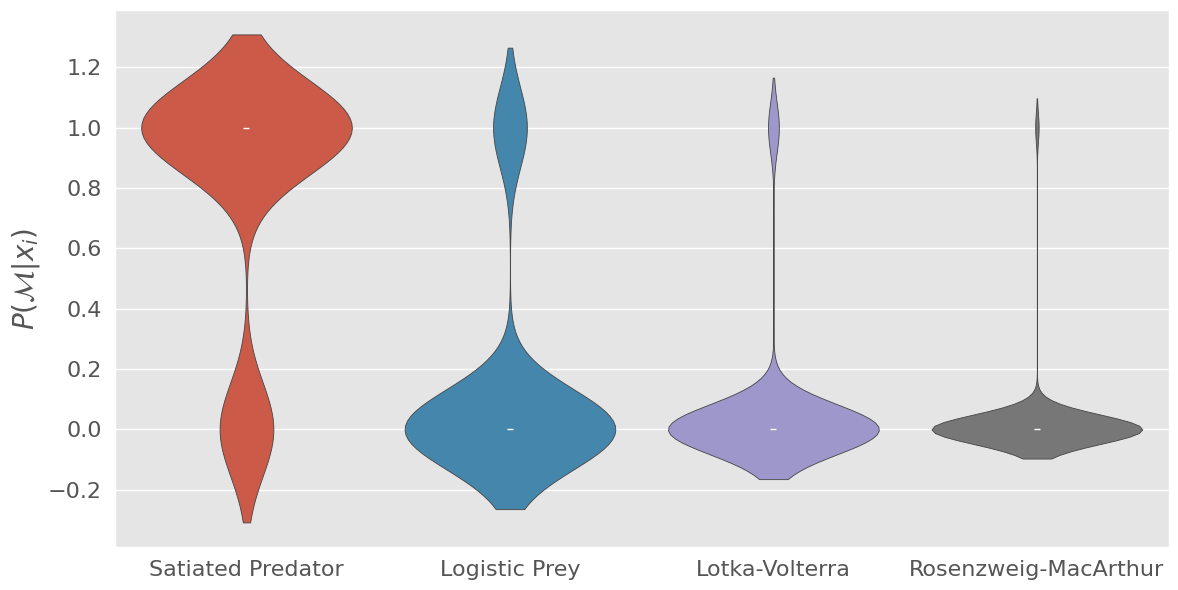

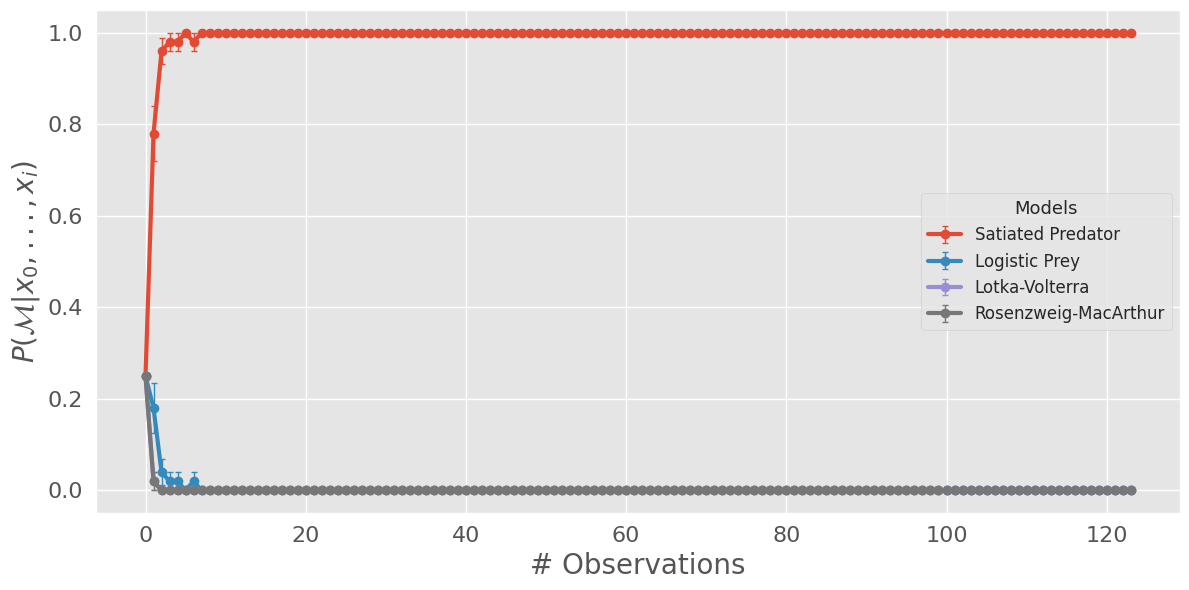

In [80]:
mtf.plot_comparison()

In [81]:
labels= ["r", "a", "m", "K"] + torch.arange(0, data.shape[1]).tolist()

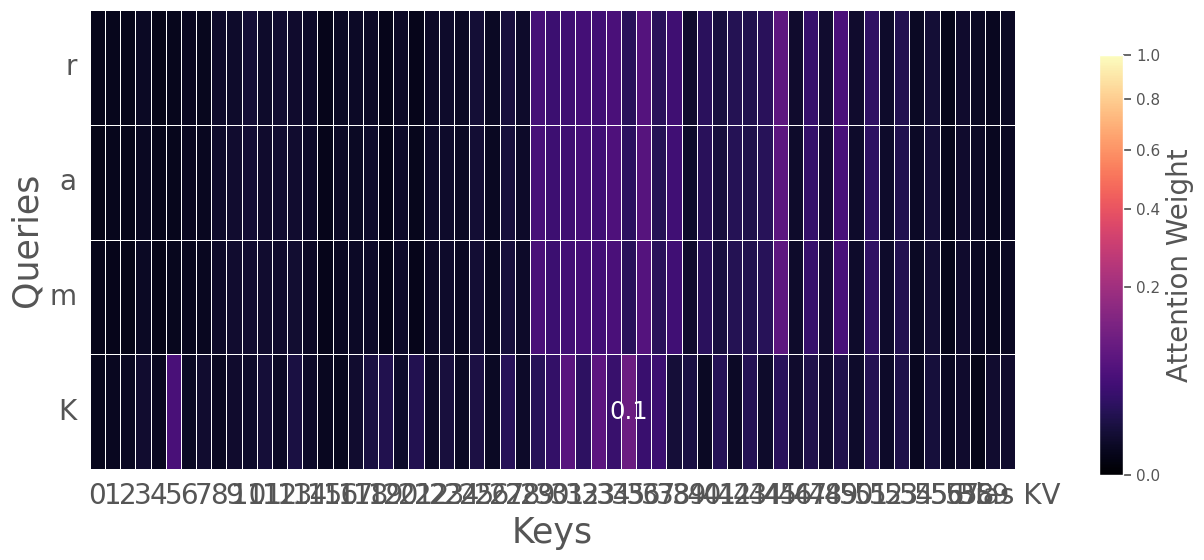

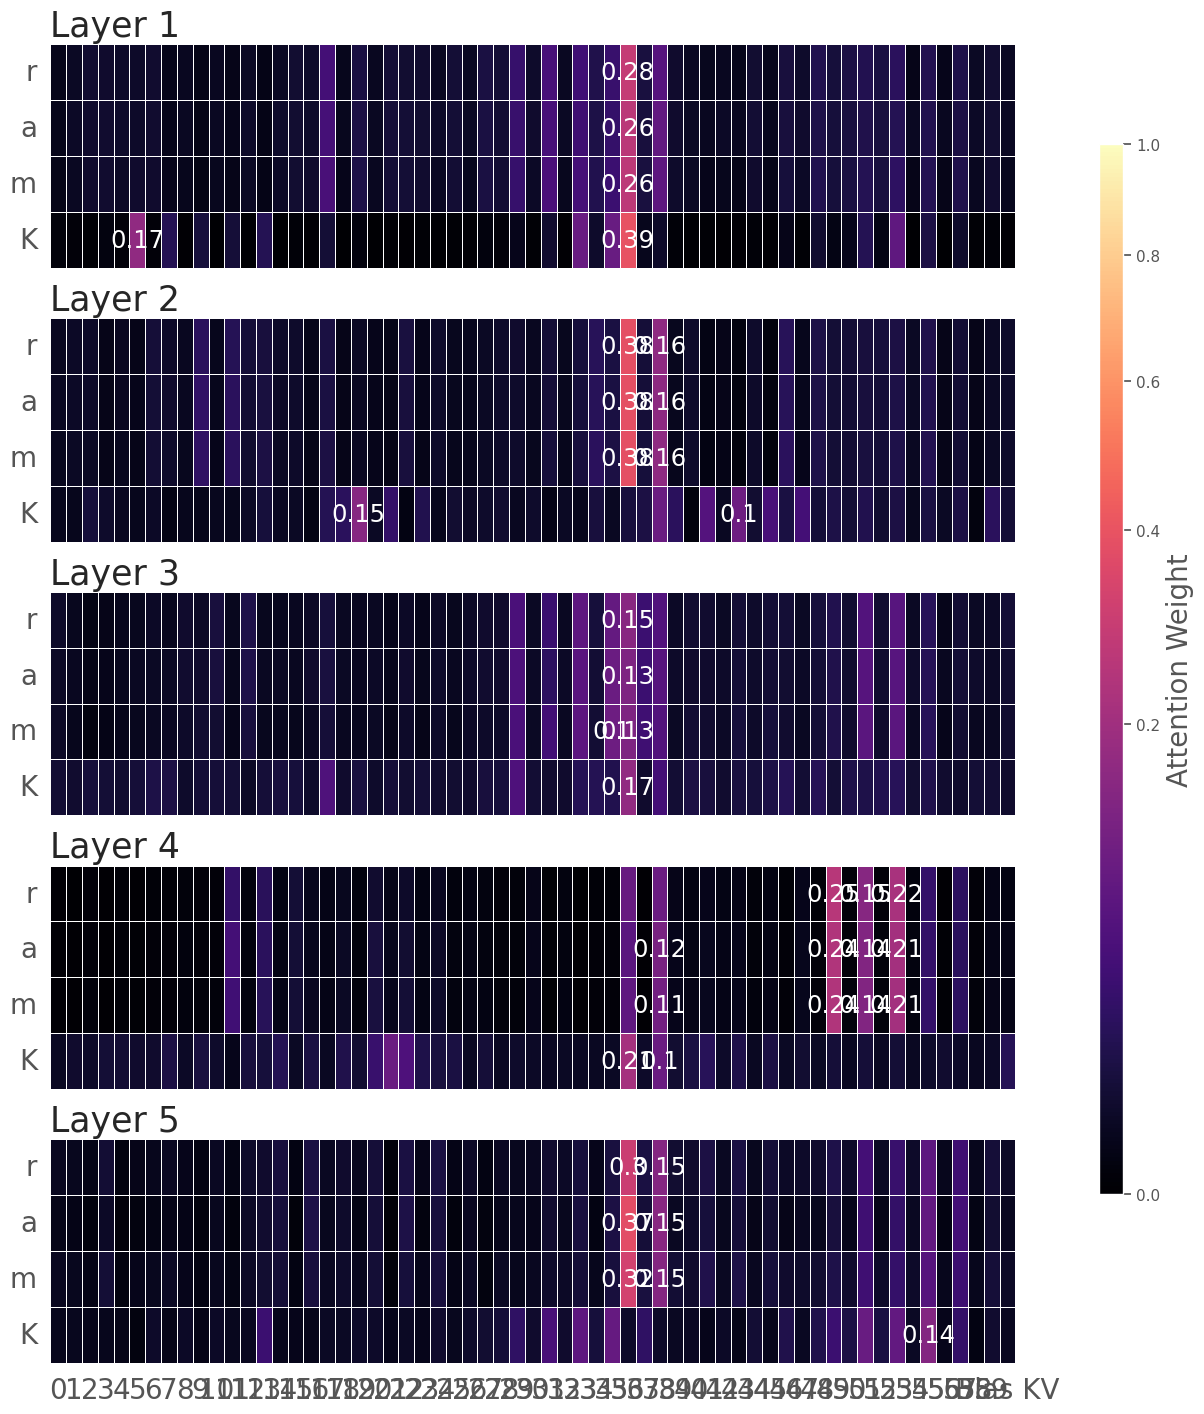

In [82]:
mtf.plot_attention(labels=labels)

In [ ]:
a = mtf.stats["Satiated Predator"]["MAP"][:,0].mean(0)

In [99]:
mtf.stats["Satiated Predator"]["MAP"][:,0]

array([[ 5.22067404,  4.92518377,  5.98553181,  0.97325498],
       [ 6.50609875,  5.733325  ,  6.60877514, -1.40972614],
       [ 6.21203852,  4.88076162,  7.12891912,  1.64886904],
       [ 6.58806896,  5.93585253,  6.55156517, -1.64939284],
       [ 8.36392307,  7.38613319,  9.89694691,  1.146873  ],
       [ 5.74982834,  5.51322412,  5.89910746, -1.50616193],
       [ 7.53138065,  5.96697378,  7.66499472,  1.8082391 ],
       [ 7.65393019,  7.65152931,  7.59850311, -2.57359195],
       [ 7.58363295,  5.7704649 ,  7.16979504,  0.15614043],
       [ 7.50684214,  7.44074392,  7.38346815, -2.49321103],
       [ 5.84334993,  5.48016453,  6.67990255,  0.76035494],
       [ 7.5395112 ,  7.41552973,  7.47083664, -2.53550506],
       [ 5.56836557,  5.63502312,  5.731318  ,  0.79771829],
       [ 8.07518291,  7.79887295,  8.06807327, -2.00685954],
       [ 6.60926199,  6.44921637,  8.10663891,  0.78847903],
       [ 6.1023612 ,  5.40534782,  5.92304087, -2.46745205],
       [ 6.63314199,  5.

In [91]:
params = a
initial_state = torch.tensor([[hare[0], lynx[0]]])

# Simulation time
t_max = 91
dt = 0.01

best_model_fn = models["Satiated Predator"]

time_best, history_best = solve_ode(best_model_fn, initial_state, params, t_max, dt)

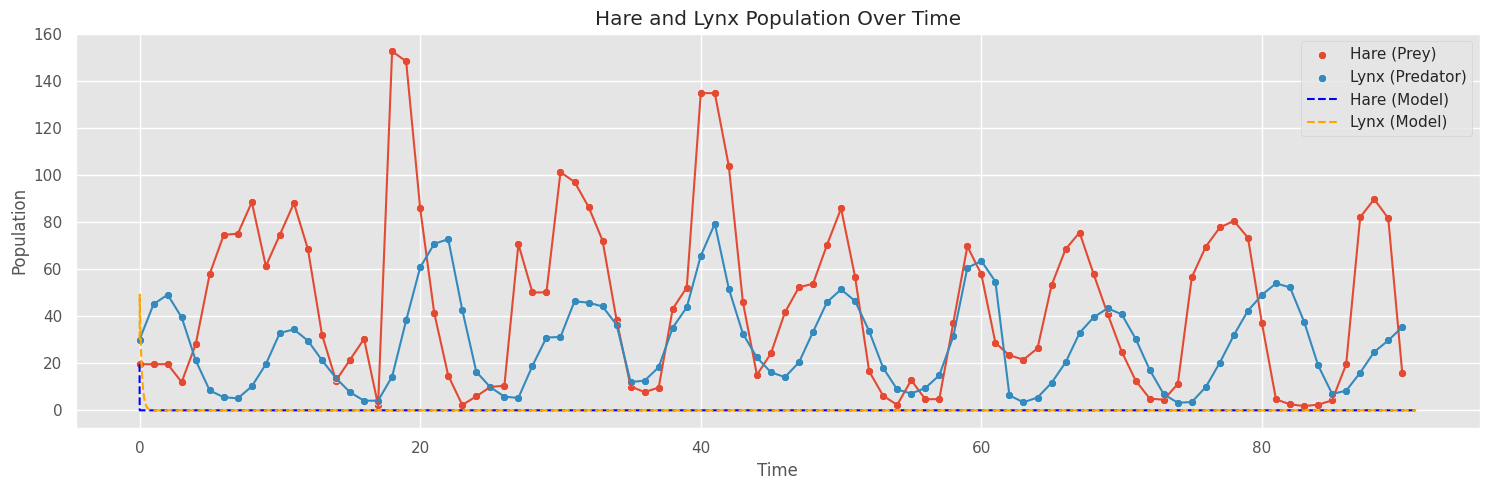

In [92]:
time = torch.tensor(df.index.values)
plt.figure(figsize=(15,5))
sns.scatterplot(x=time, y=hare, label='Hare (Prey)')
sns.lineplot(x=time, y=hare)
sns.scatterplot(x=time, y=lynx, label='Lynx (Predator)')
sns.lineplot(x=time, y=lynx)

sns.lineplot(x=time_best, y=history_best[0, :, 0], label='Hare (Model)', color='blue', linestyle='--')
sns.lineplot(x=time_best, y=history_best[0, :, 1], label='Lynx (Model)', color='orange', linestyle='--')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Hare and Lynx Population Over Time')
plt.tight_layout()
plt.show()